# TREINAMENTO REDE KCL-CNN-AUGMENTATION V2.2DACR.70e.2SL

**Rede:** KCL-CNN Editada com Augmentation
> Sem uma Conv2D, MaxPooling2D e Dropout

> Adição de camadas de Augmentation COM RANDOM INVERT

**Dataset:** Seleted Localizated

> Epochs = 70

> Batch = 32

> Target = (100, 100)

> SEED = 10

> DATA AUGMENTATION? Sim

> CLUSTERIZAÇÃO? Não

**Obs.:** Com separação de indivíduo

In [1]:
!nvidia-smi

Tue Sep 10 06:48:41 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
os.environ['TF_DISABLE_JIT'] = '1'

In [3]:
!jupyter notebook --NotebookApp.iopub_msg_rate_limit=1.0e10

[I 06:48:44.149 NotebookApp] [nb_conda_kernels] enabled, 1 kernels found

  _   _          _      _
 | | | |_ __  __| |__ _| |_ ___
 | |_| | '_ \/ _` / _` |  _/ -_)
  \___/| .__/\__,_\__,_|\__\___|
       |_|
                       
Read the migration plan to Notebook 7 to learn about the new features and the actions to take if you are using extensions.

https://jupyter-notebook.readthedocs.io/en/latest/migrate_to_notebook7.html

Please note that updating to Notebook 7 might break some of your extensions.

[I 06:48:44.474 NotebookApp] Registered dataproc_jupyter_plugin server extension
jupyter_http_over_ws extension initialized. Listening on /http_over_websocket
[I 06:48:44.743 NotebookApp] Skipped non-installed server(s): bash-language-server, dockerfile-language-server-nodejs, javascript-typescript-langserver, jedi-language-server, julia-language-server, pyright, python-language-server, r-languageserver, sql-language-server, texlab, typescript-language-server, unified-language-server

## Bibliotecas e Constantes

In [4]:
#!pip install tensorflow[and-cuda]

In [6]:
#------------------------------------------------------------------------------
# BIBLIOTECAS

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import sys
import random

# BIBLIOTECAS DEEP LEARNING
import datetime
import tensorflow as tf
import tensorflow.keras.layers as layers
from sklearn.metrics import auc, classification_report, confusion_matrix, roc_curve
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing import image
#from tf_explain.core.integrated_gradients import IntegratedGradients

#------------------------------------------------------------------------------
# CONSTANTES

DATASET_TYPE = ['cleaned', 'selected-localized', 'selected-augmentation']
DATASET_TYPE = DATASET_TYPE[1] # Dataset utilizado no treinamento

DATASET_COMPLETO = True

CNN_MODEL = 'kcl-cnn-augmentation' # Rede utilizada no treinamento

SEED = 10
np.random.seed(SEED) # semente geradora dos numeros aleatorios
random.seed(SEED)
tf.random.set_seed(SEED)

N_FOLDS = 5
N_EPOCHS = 70
BATCH_SIZE = 32
SIZE = 100
TARGET_SIZE = (SIZE, SIZE)

VERSION = '2.2DACR.70e.2SL'

## Diretórios e Carregamentos de Dados

In [7]:
# Criando pasta de resultados
if not os.path.exists(f'{DATASET_TYPE}'):
    os.mkdir(f'{DATASET_TYPE}')

In [8]:
#------------------------------------------------------------------------------
# DIRETÓRIOS DOS DATASETS

DATASET_PATH = f'/kaggle/input/myocardits-dataset-{DATASET_TYPE}'
RESULTS_PATH = f'/kaggle/working/{DATASET_TYPE}'

NORMAL_PATH = DATASET_PATH + '/Normal/'
SICK_PATH = DATASET_PATH + '/Sick/'

# Diretorios de cada Individuo:
normal_datasets = [f'{NORMAL_PATH}Individuo_{i:02}/' for i in range(1, 17)]
sick_datasets = [f'{SICK_PATH}Individuo_{i:02}/' for i in range(17, 48)]

print(normal_datasets)
print(sick_datasets)

NORMAL_SPLITS = [[9, 10, 12, 15],
                 [1,8,11],
                 [4,5,14],
                 [2,7,13],
                 [3,6,16]]

SICK_SPLITS = [[21,23,26,27,36,38],
               [18,37,39,40,41,45,46],
               [20,24,28,29,31,32],
               [19,22,30,33,42,47],
               [17,25,34,35,43,44]]

normal_splits = [[],[],[],[],[]]
sick_splits = [[],[],[],[],[]]

for split in range(N_FOLDS):
    normal_splits[split].extend(normal_datasets[i-1] for i in NORMAL_SPLITS[split])
    sick_splits[split].extend(sick_datasets[i-17] for i in SICK_SPLITS[split])

['/kaggle/input/myocardits-dataset-selected-localized/Normal/Individuo_01/', '/kaggle/input/myocardits-dataset-selected-localized/Normal/Individuo_02/', '/kaggle/input/myocardits-dataset-selected-localized/Normal/Individuo_03/', '/kaggle/input/myocardits-dataset-selected-localized/Normal/Individuo_04/', '/kaggle/input/myocardits-dataset-selected-localized/Normal/Individuo_05/', '/kaggle/input/myocardits-dataset-selected-localized/Normal/Individuo_06/', '/kaggle/input/myocardits-dataset-selected-localized/Normal/Individuo_07/', '/kaggle/input/myocardits-dataset-selected-localized/Normal/Individuo_08/', '/kaggle/input/myocardits-dataset-selected-localized/Normal/Individuo_09/', '/kaggle/input/myocardits-dataset-selected-localized/Normal/Individuo_10/', '/kaggle/input/myocardits-dataset-selected-localized/Normal/Individuo_11/', '/kaggle/input/myocardits-dataset-selected-localized/Normal/Individuo_12/', '/kaggle/input/myocardits-dataset-selected-localized/Normal/Individuo_13/', '/kaggle/in

In [9]:
#------------------------------------------------------------------------------
# CARREGAMENTO DE DADOS COM SEPARAÇÃO DE INDIVIDUOS

print('\nIniciando carregamento e processamento das imagens..............!')

def carregar_imagens(diretorio):
    global num_imagens
    imagens = []
    for pasta_atual, subpastas, arquivos in os.walk(diretorio):
        for arquivo in arquivos:
            if arquivo.endswith(('.jpg', '.jpeg', '.png')):
                caminho = os.path.join(pasta_atual, arquivo)
                
                img = Image.open(caminho)
                img = img.resize(TARGET_SIZE)
                img = img.convert('L')
                img_array = np.array(img)
                imagens.append(img_array)
                
                num_imagens += 1
                sys.stdout.write("\rNumero de imagens carregados: %i" % num_imagens)
                sys.stdout.flush()
                
    return imagens

num_imagens = 0

print('\nPacientes normais:')
normal_groups = []
for diretorios in normal_splits:
    imagens = []
    for individuos in diretorios:
        imagens.extend(carregar_imagens(individuos))
    normal_groups.append(imagens)

num_imagens = 0

print('\n\nPacientes doentes:')
sick_groups = []
for diretorios in sick_splits:
    imagens = []
    for individuos in diretorios:
        imagens.extend(carregar_imagens(individuos))
    sick_groups.append(imagens)

# DATASETS SEPRADAOS EM 5 PARA VALIDAÇÃO CRUZADA    
x_data = [[],[],[],[],[]]
y_data = [[],[],[],[],[]]

print('\n\nNumero de imagens por split:')
for i in range(N_FOLDS):
    x_data[i].extend(path for path in normal_groups[i])
    y_data[i].extend([1, 0] for path in normal_groups[i])
    x_data[i].extend(path for path in sick_groups[i])
    y_data[i].extend([0, 1] for path in sick_groups[i])
    print(f'Split {i+1}: {len(x_data[i])} imagens ({len(normal_groups[i])} saudáveis e {len(sick_groups[i])} doentes).')


Iniciando carregamento e processamento das imagens..............!

Pacientes normais:
Numero de imagens carregados: 137

Pacientes doentes:
Numero de imagens carregados: 257

Numero de imagens por split:
Split 1: 81 imagens (32 saudáveis e 49 doentes).
Split 2: 84 imagens (27 saudáveis e 57 doentes).
Split 3: 76 imagens (26 saudáveis e 50 doentes).
Split 4: 77 imagens (26 saudáveis e 51 doentes).
Split 5: 76 imagens (26 saudáveis e 50 doentes).


## Treinamento

In [18]:
import tensorflow as tf
from tensorflow.keras import layers

def random_invert_img(x, factor):
    """Função para aplicar inversão e contraste de forma condicional."""
    return tf.cond(
        tf.less(tf.random.uniform([]), factor),  # Se tf.random.uniform for menor que o fator
        lambda: tf.image.adjust_contrast((1 - x) - 0.6, 1.0),  # Aplica a inversão e ajusta o contraste
        lambda: x  # Caso contrário, retorna a imagem original
    )

def random_invert_layer(factor):
    """Camada personalizada para inversão de imagem com especificação de output_shape."""
    return layers.Lambda(lambda x: random_invert_img(x, factor), output_shape=lambda s: s)

def cnn_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    # Aumentação de dados
    x = layers.RandomFlip("horizontal_and_vertical")(inputs)
    x = layers.RandomRotation(0.2)(x)
    x = layers.RandomContrast(0.5)(x)
    x = layers.RandomZoom(0.2)(x)
    
    # Aplicação de inversão personalizada
    x = random_invert_layer(0.5)(x)
    
    # Camadas convolucionais
    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Flatten()(x)
    
    # Camadas densas
    x = layers.Dense(100, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    # Criação do modelo
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.summary()
    return model

In [19]:
#------------------------------------------------------------------------------
# SEPARAÇÃO DE DADOS E TREINAMENTO

lst_accuracy=[]
lst_accuracy_v=[]
lst_acc=[]
lst_loss=[]
lst_reports=[]
lst_AUC=[]
lst_matrix=[]
lst_matrix_v=[]
lst_times=[]
lst_history=[]

#------------------------------------------------------------------------------
# TREINAMENTO POR FOLDS

for fold in range(N_FOLDS):

    print(f'\n\nFOLD {fold+1}:')

    #--------------------------------------------------------------------------
    # Carregamento dos dados de treinamento, validação e teste
    
    x_test = np.array(x_data[fold])
    y_test = np.array(y_data[fold])
    
    folds = [0, 1, 2, 3, 4]
    folds.remove(fold)

    x_valid = np.array(x_data[folds[0]])
    y_valid = np.array(y_data[folds[0]])
    folds.remove(folds[0])

    x_train, y_train = [], []
    for i in folds:
        x_train.extend(x_data[i])
        y_train.extend(y_data[i])
    x_train = np.array(x_train)
    y_train = np.array(y_train)

    print(f'Numero de imagens no treinamento: {len(x_train)} imagens.')
    print(f'Numero de imagens na validação: {len(x_valid)} imagens.')
    print(f'Numero de imagens no teste: {len(x_test)} imagens.')

    #--------------------------------------------------------------------------
    # Arquitetura e compilação

    model = cnn_model((SIZE, SIZE, 1), 2)
    
    OPTIMIZER = AdamW(weight_decay=0.004)
    
    # Compilação do modelo
    model.compile(loss='categorical_crossentropy',
                  optimizer=OPTIMIZER,
                  metrics=['categorical_accuracy'])

    #--------------------------------------------------------------------------
    # Treinamento
    
    print('\nIniciando o treinamento.........................................!\n')

    calback = CSVLogger(RESULTS_PATH + f'/logger_fold{fold+1}.log')

    # Treinamento com augmentação
    start = datetime.datetime.now()

    history = model.fit(x_train, y_train,
                        epochs=N_EPOCHS,
                        validation_data=(x_valid, y_valid),
                        callbacks=[calback])

    end = datetime.datetime.now()
    training_time = end - start

    # Salvando o modelo
    model.save(RESULTS_PATH + f'/{DATASET_TYPE}-CNN-{fold+1}.keras')

    #--------------------------------------------------------------------------
    # Teste
    print("\nTestando imagens................................................!\n")
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print(model.metrics_names)

    #--------------------------------------------------------------------------
    # ARMAZENAMENTO DOS INFORMACOES

    # Fazendo previsões
    predicts = model.predict(x_test)
    predicts = predicts.argmax(axis=1)

    # Obtendo os rótulos verdadeiros
    actuals=y_test.argmax(axis=1)

    # Calculando a curva ROC
    fpr, tpr, _ = roc_curve(actuals, predicts, pos_label=1)
    a = auc(fpr, tpr)

    # Gerando o relatório de classificação
    r = classification_report(actuals, predicts, zero_division=1)

    # Calculando a matriz de confusão
    c = confusion_matrix(actuals, predicts)
    accuracy = np.trace(c)/np.sum(c)
    
    # Validação
    # Fazendo previsões
    predicts_v = model.predict(x_valid)
    predicts_v = predicts_v.argmax(axis=1)

    # Obtendo os rótulos verdadeiros
    actuals_v=y_valid.argmax(axis=1)
    
    # Calculando a matriz de confusão
    c_v = confusion_matrix(actuals, predicts)
    accuracy_v = np.trace(c)/np.sum(c)

    lst_history.append(history)
    lst_times.append(training_time)
    lst_accuracy.append(accuracy)
    lst_acc.append(test_acc)
    lst_loss.append(test_loss)
    lst_AUC.append(a)
    lst_reports.append(r)
    lst_matrix.append(c)
    
    lst_accuracy_v.append(accuracy_v)
    lst_matrix_v.append(c_v)



FOLD 1:
Numero de imagens no treinamento: 229 imagens.
Numero de imagens na validação: 84 imagens.
Numero de imagens no teste: 81 imagens.


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 100, 100, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_6 (RandomFlip)      │ (None, 100, 100, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_6               │ (None, 100, 100, 1)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_6               │ (None, 100, 100, 1)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_6 (RandomZoom)      │ (None, 100, 100, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 100, 100, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 98, 98, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 33856)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 100)            │     3,385,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,404,718 (12.99 MB)

 Trainable params: 3,404,718 (12.99 MB)

 Non-trainable params: 0 (0.00 B)


Iniciando o treinamento.........................................!

Epoch 1/70
1/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - categorical_accuracy: 0.5000 - loss: 3.3492

2024-09-10 06:53:02.553228: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_13_1/dropout_18_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - categorical_accuracy: 0.5823 - loss: 102.5331 - val_categorical_accuracy: 0.0595 - val_loss: 28.2675
Epoch 2/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.5529 - loss: 26.0050 - val_categorical_accuracy: 0.6786 - val_loss: 5.5700
Epoch 3/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_accuracy: 0.5672 - loss: 10.9187 - val_categorical_accuracy: 0.0833 - val_loss: 2.9131
Epoch 4/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.5326 - loss: 2.8344 - val_categorical_accuracy: 0.6667 - val_loss: 0.5399
Epoch 5/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.5942 - loss: 0.8924 - val_categorical_accuracy: 0.4167 - val_loss: 0.7631
Epoch 6/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.5373 - loss: 0.8019 - val_categorical_accuracy: 0.7738 - val_loss: 0.6371
Epoch 7/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.5403 - loss: 0.7446 - val_categorical

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 100, 100, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_7 (RandomFlip)      │ (None, 100, 100, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_7               │ (None, 100, 100, 1)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_7               │ (None, 100, 100, 1)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_7 (RandomZoom)      │ (None, 100, 100, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 100, 100, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 98, 98, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 33856)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 100)            │     3,385,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,404,718 (12.99 MB)

 Trainable params: 3,404,718 (12.99 MB)

 Non-trainable params: 0 (0.00 B)


Iniciando o treinamento.........................................!

Epoch 1/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - categorical_accuracy: 0.4630 - loss: 114.8446 - val_categorical_accuracy: 0.3580 - val_loss: 82.3447
Epoch 2/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.5199 - loss: 37.3205 - val_categorical_accuracy: 0.6049 - val_loss: 0.5367
Epoch 3/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.5891 - loss: 3.3455 - val_categorical_accuracy: 0.6049 - val_loss: 0.8712
Epoch 4/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.6632 - loss: 0.7030 - val_categorical_accuracy: 0.6049 - val_loss: 0.7204
Epoch 5/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.6632 - loss: 0.6822 - val_categorical_accuracy: 0.6049 - val_loss: 0.6882
Epoch 6/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.6632 - loss: 0.6793 - val_categorical_accuracy: 0.6049 - val_loss: 0.7071
Epoch 7/70
8/8 ━━━━━━━━━━━━━━━━━━━

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 100, 100, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_8 (RandomFlip)      │ (None, 100, 100, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_8               │ (None, 100, 100, 1)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_8               │ (None, 100, 100, 1)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_8 (RandomZoom)      │ (None, 100, 100, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_3 (Lambda)               │ (None, 100, 100, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 98, 98, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 33856)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 100)            │     3,385,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,404,718 (12.99 MB)

 Trainable params: 3,404,718 (12.99 MB)

 Non-trainable params: 0 (0.00 B)


Iniciando o treinamento.........................................!

Epoch 1/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - categorical_accuracy: 0.4553 - loss: 166.6543 - val_categorical_accuracy: 0.6049 - val_loss: 55.5615
Epoch 2/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.6347 - loss: 23.2515 - val_categorical_accuracy: 0.6049 - val_loss: 1.1616
Epoch 3/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.6116 - loss: 20.9657 - val_categorical_accuracy: 0.7778 - val_loss: 0.2595
Epoch 4/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.5903 - loss: 3.5304 - val_categorical_accuracy: 0.6049 - val_loss: 0.4337
Epoch 5/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.6798 - loss: 1.6969 - val_categorical_accuracy: 0.6049 - val_loss: 0.6926
Epoch 6/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.6798 - loss: 0.6922 - val_categorical_accuracy: 0.6049 - val_loss: 0.6922
Epoch 7/70
8/8 ━━━━━━━━━━━━━━━━━━

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 100, 100, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_9 (RandomFlip)      │ (None, 100, 100, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_9               │ (None, 100, 100, 1)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_9               │ (None, 100, 100, 1)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_9 (RandomZoom)      │ (None, 100, 100, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_4 (Lambda)               │ (None, 100, 100, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 98, 98, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 33856)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 100)            │     3,385,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,404,718 (12.99 MB)

 Trainable params: 3,404,718 (12.99 MB)

 Non-trainable params: 0 (0.00 B)


Iniciando o treinamento.........................................!

Epoch 1/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - categorical_accuracy: 0.5299 - loss: 222.4368 - val_categorical_accuracy: 0.6049 - val_loss: 83.1918
Epoch 2/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.6427 - loss: 89.3619 - val_categorical_accuracy: 0.7901 - val_loss: 0.5830
Epoch 3/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.4447 - loss: 5.7499 - val_categorical_accuracy: 0.6296 - val_loss: 0.4937
Epoch 4/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.3857 - loss: 0.7186 - val_categorical_accuracy: 0.5802 - val_loss: 0.6696
Epoch 5/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.3709 - loss: 0.6965 - val_categorical_accuracy: 0.6049 - val_loss: 0.6721
Epoch 6/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.6418 - loss: 0.6915 - val_categorical_accuracy: 0.6049 - val_loss: 0.5934
Epoch 7/70
8/8 ━━━━━━━━━━━━━━━━━━━

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 100, 100, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_10 (RandomFlip)     │ (None, 100, 100, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_10              │ (None, 100, 100, 1)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_10              │ (None, 100, 100, 1)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_10 (RandomZoom)     │ (None, 100, 100, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_5 (Lambda)               │ (None, 100, 100, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 98, 98, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 33856)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 100)            │     3,385,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,404,718 (12.99 MB)

 Trainable params: 3,404,718 (12.99 MB)

 Non-trainable params: 0 (0.00 B)


Iniciando o treinamento.........................................!

Epoch 1/70
1/8 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - categorical_accuracy: 0.5312 - loss: 7.5186

2024-09-10 06:54:02.559075: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_21_1/dropout_30_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - categorical_accuracy: 0.5181 - loss: 98.4093 - val_categorical_accuracy: 0.7037 - val_loss: 3.0556
Epoch 2/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_accuracy: 0.5562 - loss: 7.7772 - val_categorical_accuracy: 0.6667 - val_loss: 0.5050
Epoch 3/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.6108 - loss: 3.4188 - val_categorical_accuracy: 0.2963 - val_loss: 0.7207
Epoch 4/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.5878 - loss: 0.7145 - val_categorical_accuracy: 0.2840 - val_loss: 0.7014
Epoch 5/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.6244 - loss: 0.6416 - val_categorical_accuracy: 0.5556 - val_loss: 0.6895
Epoch 6/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.5760 - loss: 0.6521 - val_categorical_accuracy: 0.5926 - val_loss: 0.6942
Epoch 7/70
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.6176 - loss: 0.6605 - val_categorical_acc

In [20]:
'''from matplotlib import cm
from tensorflow.keras.models import load_model
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize

def visualize_gradcam(model, img_array, image_title):
    # Ensure the input image array has the correct shape and type
    img_array = np.expand_dims(img_array, axis=-1)  # Ensure it has a single channel if needed
    img_array = np.expand_dims(img_array, axis=0)   # Add batch dimension if needed
    img_array = img_array.astype(np.float32)        # Convert to float32 if needed

    # Create Gradcam object
    gradcam = Gradcam(model,
                      model_modifier=None,  # Modify if needed
                      clone=True)

    # Define a função de pontuação (score function)
    def score_function(output):
        return output[:, np.argmax(output[0])]  # Use o índice da classe com maior probabilidade

    # Generate heatmap with GradCAM
    cam = gradcam(score=score_function,
                  penultimate_layer=-1,  # Index of the penultimate layer
                  seed_input=img_array)

    # Process the heatmap for visualization
    heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)  # Apply colormap and convert to uint8
    heatmap = np.squeeze(heatmap)  # Remove single-dimensional entries from the shape of an array

    # Render
    plt.figure(figsize=(6, 4))
    plt.title(image_title, fontsize=16)
    plt.imshow(img_array[0, :, :, 0], cmap='gray', alpha=0.5)  # Show the grayscale image
    plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay heatmap
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Carregar o modelo treinado
model = load_model(RESULTS_PATH + f'/{DATASET_TYPE}-CNN-{fold+1}.keras')

# Imagens de teste
imgs_array = []

for i in range(N_FOLDS):
        imgs_array.append(x_data[i][0])
imgs_array = np.array(imgs_array)

for img_array in imgs_array:
    image_title = 'Mapa de Calor'

    # Visualizar com GRAD-CAM
    visualize_gradcam(model, img_array, image_title)'''

"from matplotlib import cm\nfrom tensorflow.keras.models import load_model\nfrom tf_keras_vis.gradcam import Gradcam\nfrom tf_keras_vis.utils import normalize\n\ndef visualize_gradcam(model, img_array, image_title):\n    # Ensure the input image array has the correct shape and type\n    img_array = np.expand_dims(img_array, axis=-1)  # Ensure it has a single channel if needed\n    img_array = np.expand_dims(img_array, axis=0)   # Add batch dimension if needed\n    img_array = img_array.astype(np.float32)        # Convert to float32 if needed\n\n    # Create Gradcam object\n    gradcam = Gradcam(model,\n                      model_modifier=None,  # Modify if needed\n                      clone=True)\n\n    # Define a função de pontuação (score function)\n    def score_function(output):\n        return output[:, np.argmax(output[0])]  # Use o índice da classe com maior probabilidade\n\n    # Generate heatmap with GradCAM\n    cam = gradcam(score=score_function,\n                  penulti

## Salvamento de Dados

In [21]:
#--------------------------------------------------------------------------
# SALVAMENTO DOS DADOS

print('\nSalvando informações da rede......................................!')

path = RESULTS_PATH + f'/results-v{VERSION}.txt'
    
matrix_total = np.sum(lst_matrix, axis=0)
accuracy_total = np.trace(matrix_total)/np.sum(matrix_total)

matrix_total_v = np.sum(lst_matrix_v, axis=0)
accuracy_total_v = np.trace(matrix_total_v)/np.sum(matrix_total_v)
    
losses=[]
val_losses=[]
accuracies=[]
val_accuracies=[]

for item in lst_history:
    
    history=item.history
    loss=history['loss']
    accuracy=history['categorical_accuracy']
    
    val_loss=history['val_loss']
    val_accuracy=history['val_categorical_accuracy']
    
    losses.append(sum(loss)/len(loss))
    accuracies.append(sum(accuracy)/len(accuracy))
    
    val_losses.append(sum(val_loss)/len(val_loss))
    val_accuracies.append(sum(val_accuracy)/len(val_accuracy))

f1=open(path,'w')
f1.write(f'TREINAMENTO v{VERSION}\n')

f1.write('\nTest Accuracias: '+str(lst_acc)+'\nTest Losses: '+str(lst_loss))
f1.write('\n\nTest Accuracies Mean: '+str(np.mean(lst_acc)))

f1.write('\n\n__________________________________________________________\n')

f1.write('\n\nValid Accuracies: '+str(val_accuracies)+'\nValid Losses: '+str(val_losses))
f1.write('\n\nValid Accuracies Mean: '+str(np.mean(val_accuracies)))

f1.write('\n\n__________________________________________________________\n')

f1.write('\nAccuracies from Confusion Matrix: '+str(lst_accuracy))

f1.write('\n\nTotal Confusion Matrix: \n'+str(matrix_total)+'\n\n')
f1.write('\nTotal Accuracie from Confusion Matrix: '+str(accuracy_total))

f1.write('\n\n__________________________________________________________\n')

f1.write('\n\nTotal Confusion Matrix Valid: \n'+str(matrix_total_v)+'\n\n')
f1.write('\nTotal Accuracie from Confusion Matrix Valid: '+str(accuracy_total_v))

f1.write('\n\n__________________________________________________________\n')

f1.write('\n\nMetrics for all Folds: \n\n')
for i in range(len(lst_reports)):
    f1.write(str(lst_reports[i]))
    f1.write('\n\nTraining Time: '+str(lst_times[i])+'\nAUC: '+str(lst_AUC[i]))
    f1.write('\n\nAcurácia: ' + str(lst_accuracy[i]))
    f1.write('\n\nMatriz de Confusao: \n'+str(lst_matrix[i])+'\n\n__________________________________________________________\n')
f1.close()


Salvando informações da rede......................................!


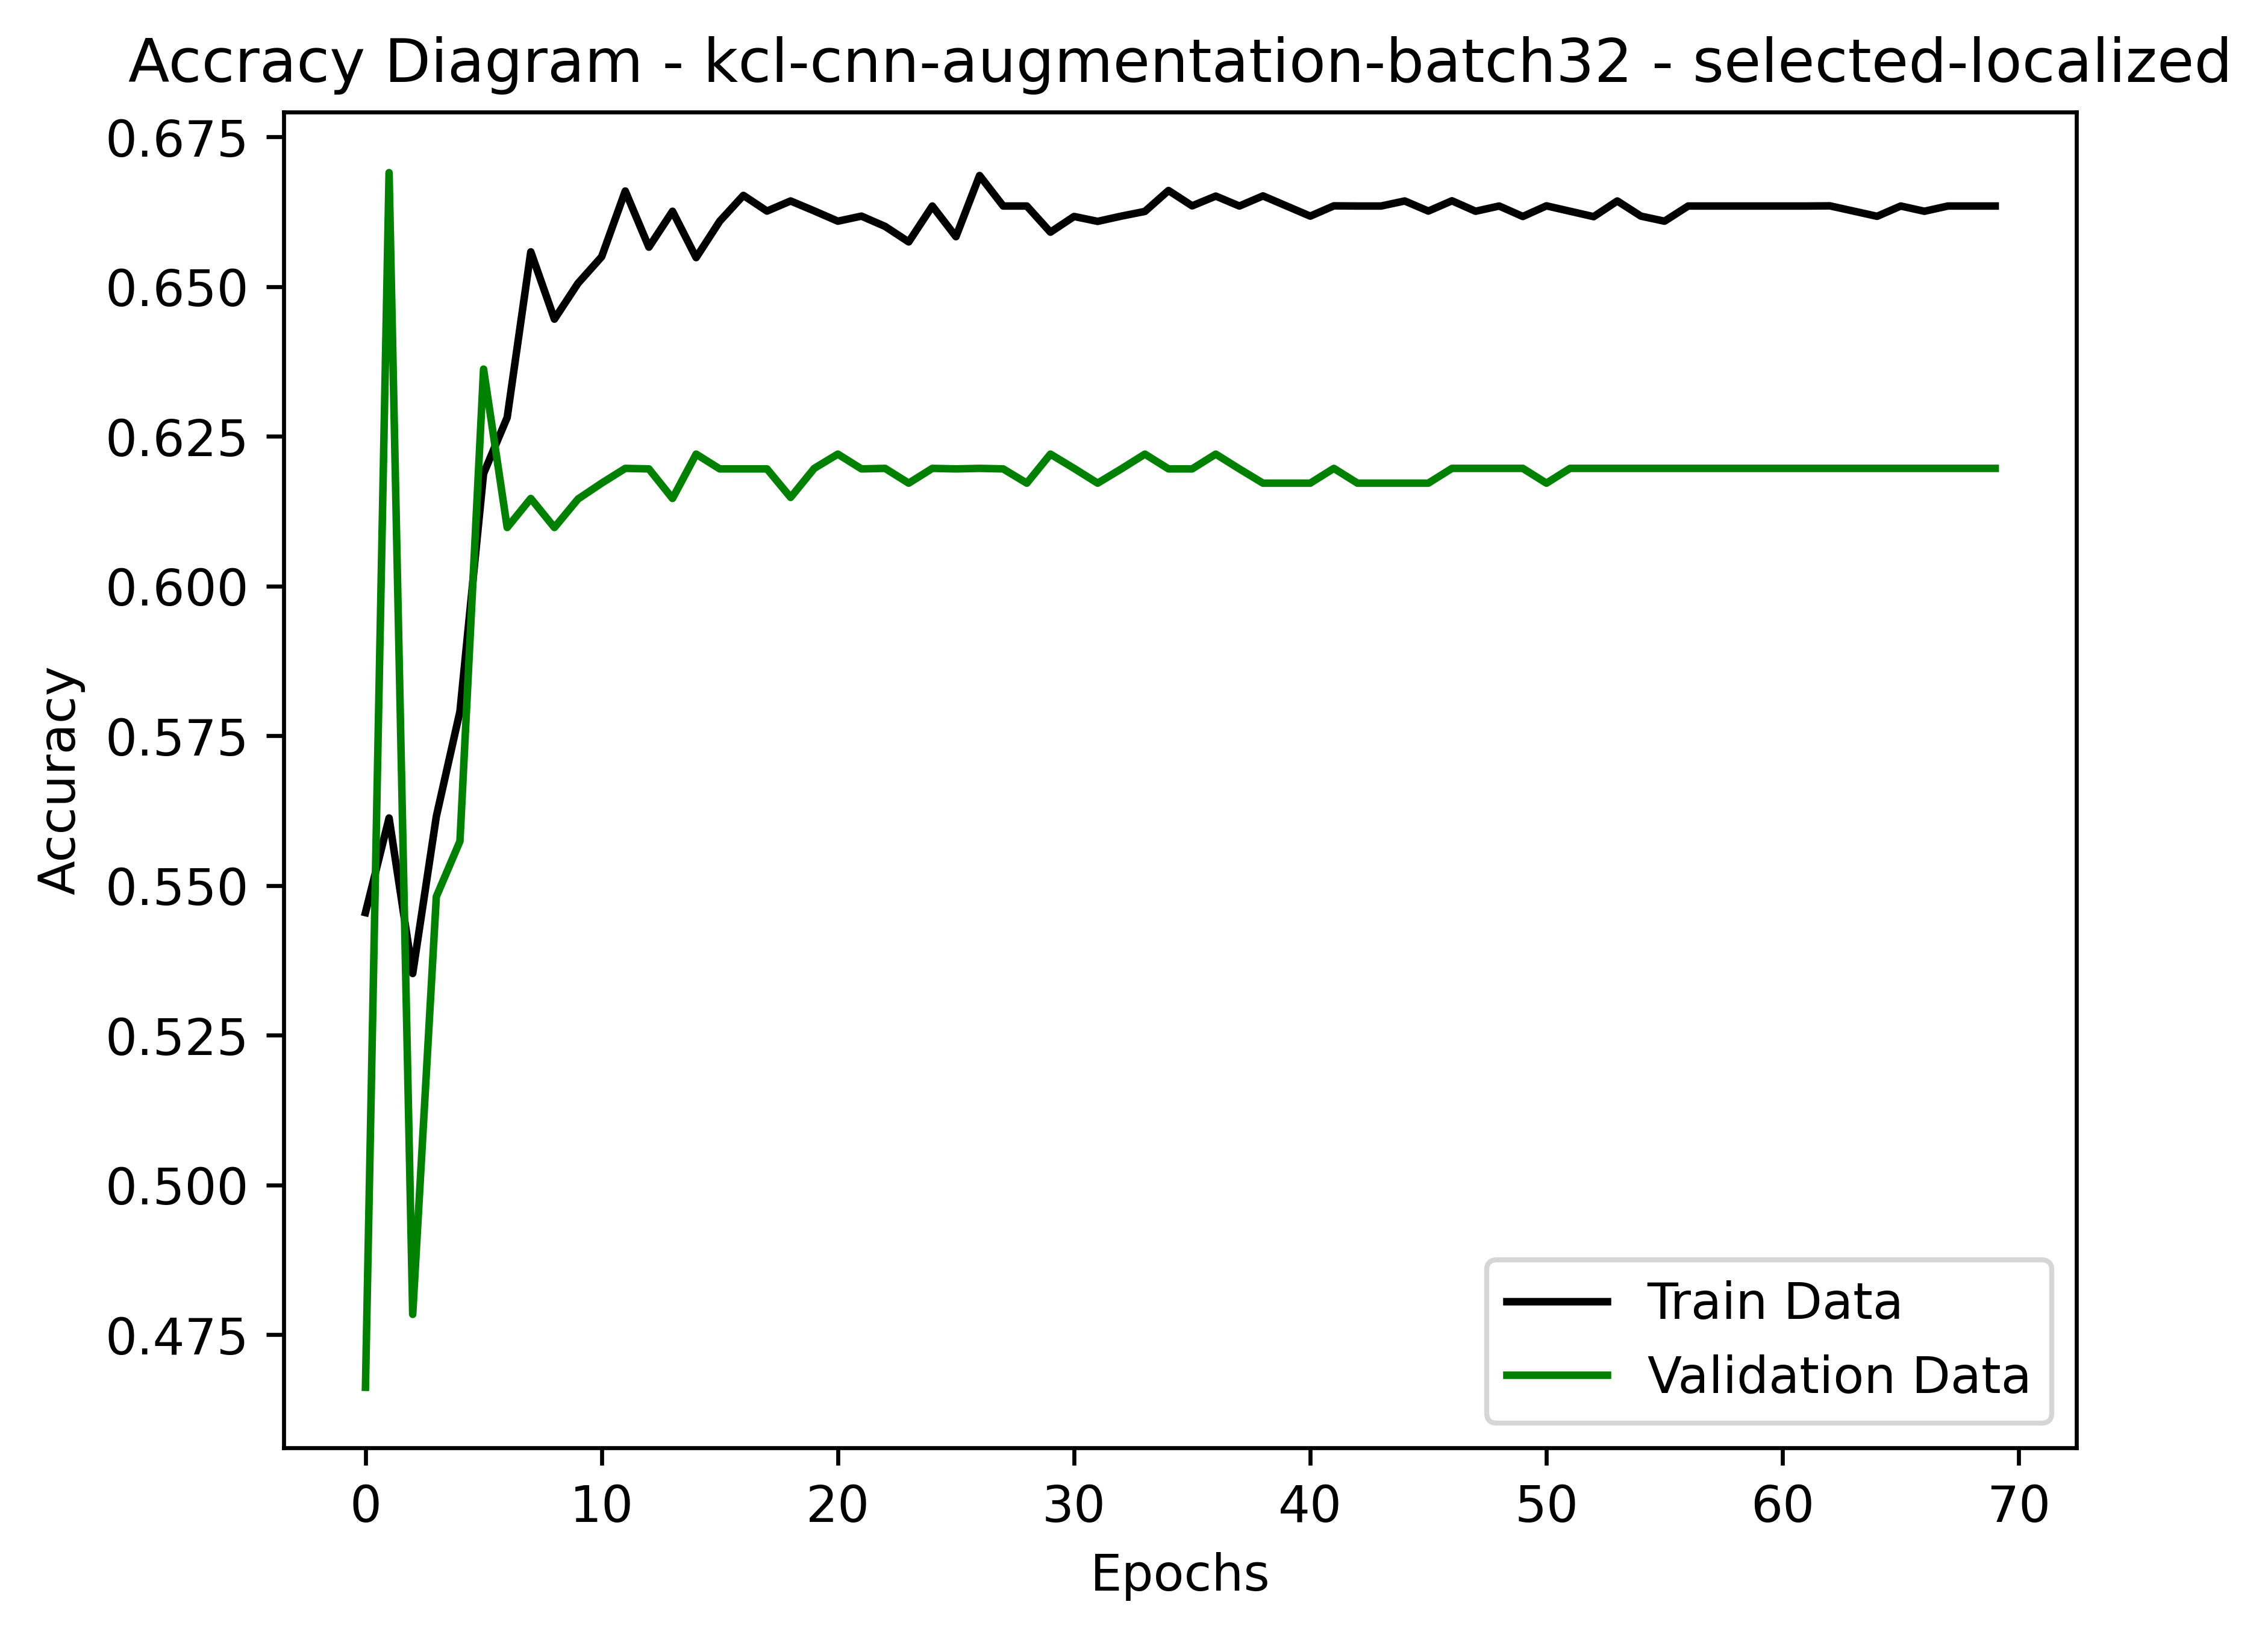

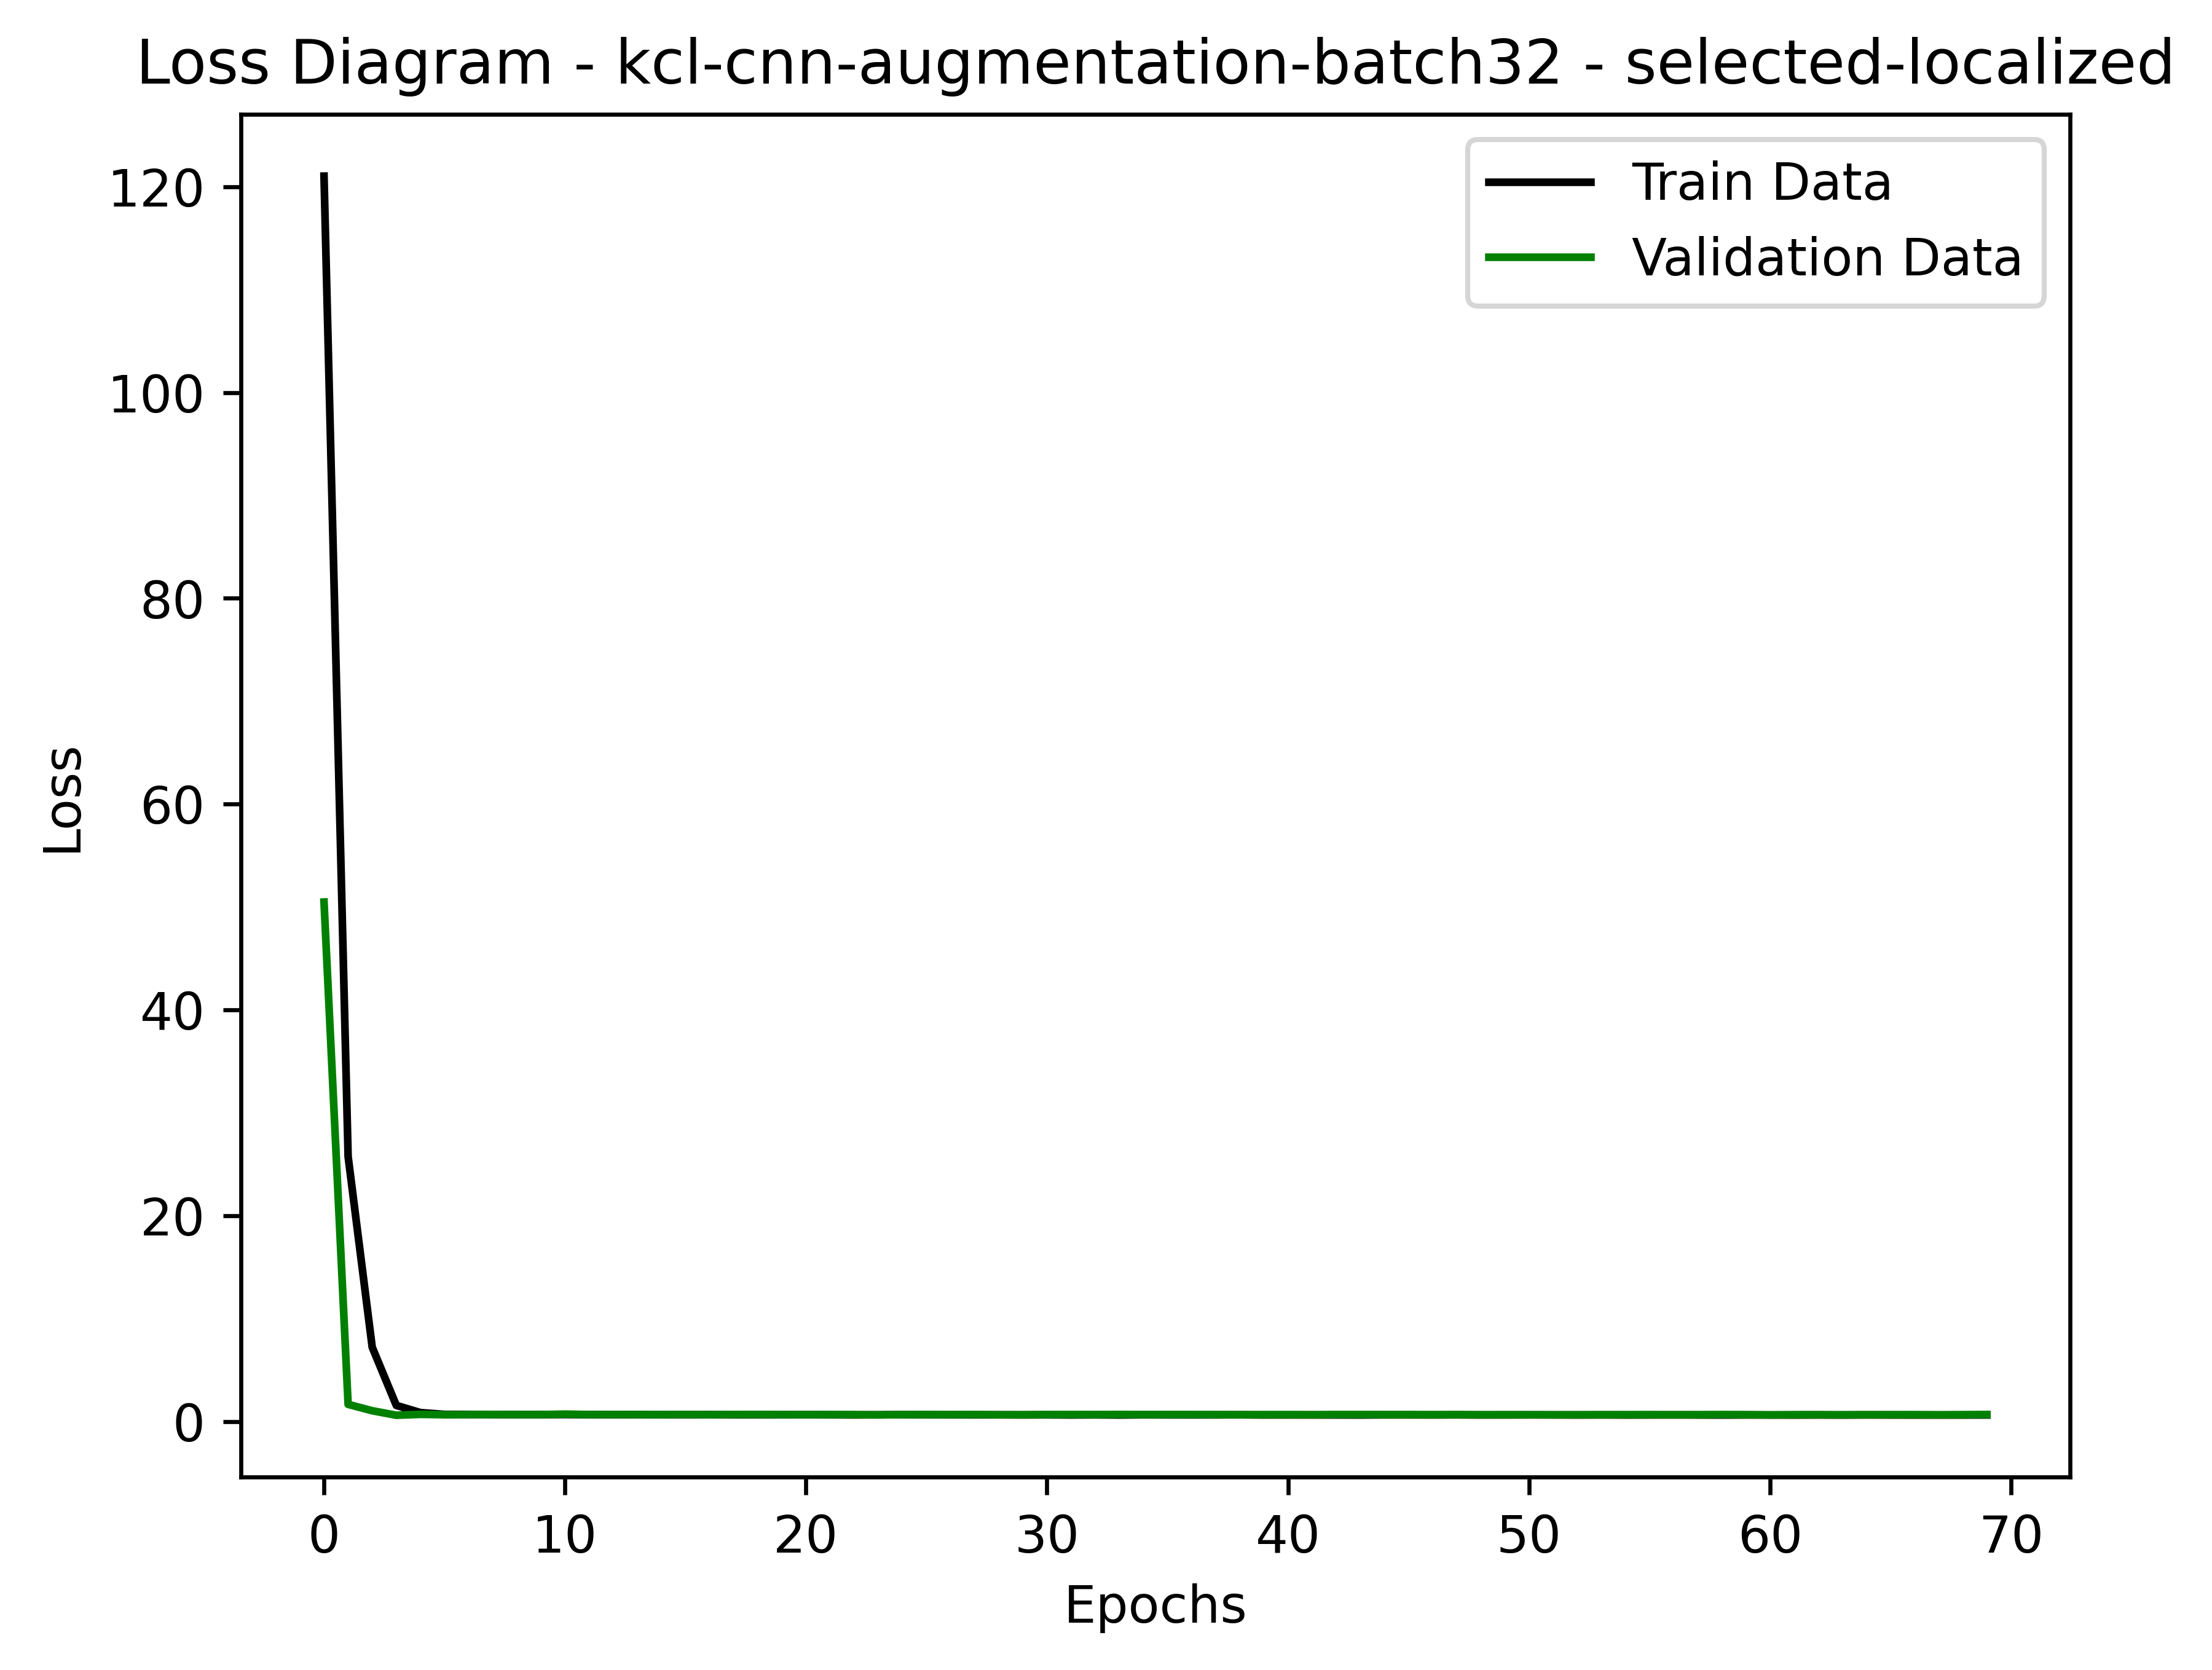

In [22]:
def NetPlot(net_histories,n_epch):
    import numpy as np
    import matplotlib.pyplot as plt

    losses=[]
    val_losses=[]
    accuracies=[]
    val_accuracies=[]

    for item in net_histories:

        history=item.history
        loss=history['loss']
        val_loss=history['val_loss']
        accuracy=history['categorical_accuracy']
        val_accuracy=history['val_categorical_accuracy']

        losses.append(loss)
        val_losses.append(val_loss)
        accuracies.append(accuracy)
        val_accuracies.append(val_accuracy)


    losses2=np.zeros((1,n_epch))
    val_losses2=np.zeros((1,n_epch))
    accuracies2=np.zeros((1,n_epch))
    val_accuracies2=np.zeros((1,n_epch))

    for i in losses:
        losses2+=i

    for i in val_losses:
        val_losses2+=i

    for i in accuracies:
        accuracies2+=i

    for i in val_accuracies:
        val_accuracies2+=i
        
    N_SPLITS = 5

    # 10 is number of folds
    losses2=(losses2/N_SPLITS).flatten()
    accuracies2=(accuracies2/N_SPLITS).flatten()
    val_losses2=(val_losses2/N_SPLITS).flatten()
    val_accuracies2=(val_accuracies2/N_SPLITS).flatten()
    
    # print('\nAccuracies: '+ str(accuracies2) +'\nLosses: '+ str(losses2))

    plt.figure('Accracy Diagram',dpi=600)
    plt.title(f'Accracy Diagram - {CNN_MODEL}-batch{BATCH_SIZE} - {DATASET_TYPE}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(accuracies2,color='black')
    plt.plot(val_accuracies2,color='green')
    plt.legend(['Train Data','Validation Data'])
    plt.savefig(f'{RESULTS_PATH}/Accuracy-Diagram-{CNN_MODEL}-batch{BATCH_SIZE}.jpg')

    plt.figure('Loss Diagram',dpi=600)
    plt.title(f'Loss Diagram - {CNN_MODEL}-batch{BATCH_SIZE} - {DATASET_TYPE}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(losses2,color='black')
    plt.plot(val_losses2,color='green')
    plt.legend(['Train Data','Validation Data'])
    plt.savefig(f'{RESULTS_PATH}/Loss-Diagram-{CNN_MODEL}-batch{BATCH_SIZE}.jpg')
    
NetPlot(lst_history,N_EPOCHS)

In [23]:
# Zipando pasta com resultados
import zipfile

def compactar_pasta(pasta, nome_arquivo_zip):
    with zipfile.ZipFile(nome_arquivo_zip, 'w', zipfile.ZIP_DEFLATED) as zip_file:
        for root, _, files in os.walk(pasta):
            for arquivo in files:
                caminho_completo = os.path.join(root, arquivo)
                zip_file.write(caminho_completo, os.path.relpath(caminho_completo, pasta))

nome_arquivo_zip = f'{VERSION}-results.zip'
compactar_pasta(RESULTS_PATH, nome_arquivo_zip)